In [1]:
!which python

/scratch/shri/shri3/bin/python


In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
import cv2


/scratch/shri/shri3/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/scratch/shri/shri3/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/scratch/shri/shri3/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/scratch/shri/shri3/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [4]:
class handConfig(Config):
    
    NAME = "hand"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  
    STEPS_PER_EPOCH = 1000
    # DETECTION_MIN_CONFIDENCE = 0.1
    # RPN_NMS_THRESHOLD = 0.1

    # DETECTION_NMS_THRESHOLD = 0.1
    # tf.global_variables_initializer()



class InferenceConfig(handConfig):
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
# config.display()

In [38]:
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def load_model_custom(config):
#     with tf.device(DEVICE):

    model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./model')
    model.load_weights('./model/trained_weights.h5', by_name=True)
        # print(model.summary())

    return model
model = load_model_custom(InferenceConfig())





(None, None, None, 1024)
SHape of theta = (?, 4096, 256) Shape of fi (?, 4096, 256)
SHape of f = (?, 4096, 4096) Shape of g (?, 4096, 256)



(None, None, None, 1024)
SHape of theta = (?, 4096, 256) Shape of fi (?, 4096, 256)
SHape of f = (?, 4096, 4096) Shape of g (?, 4096, 256)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.


In [7]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

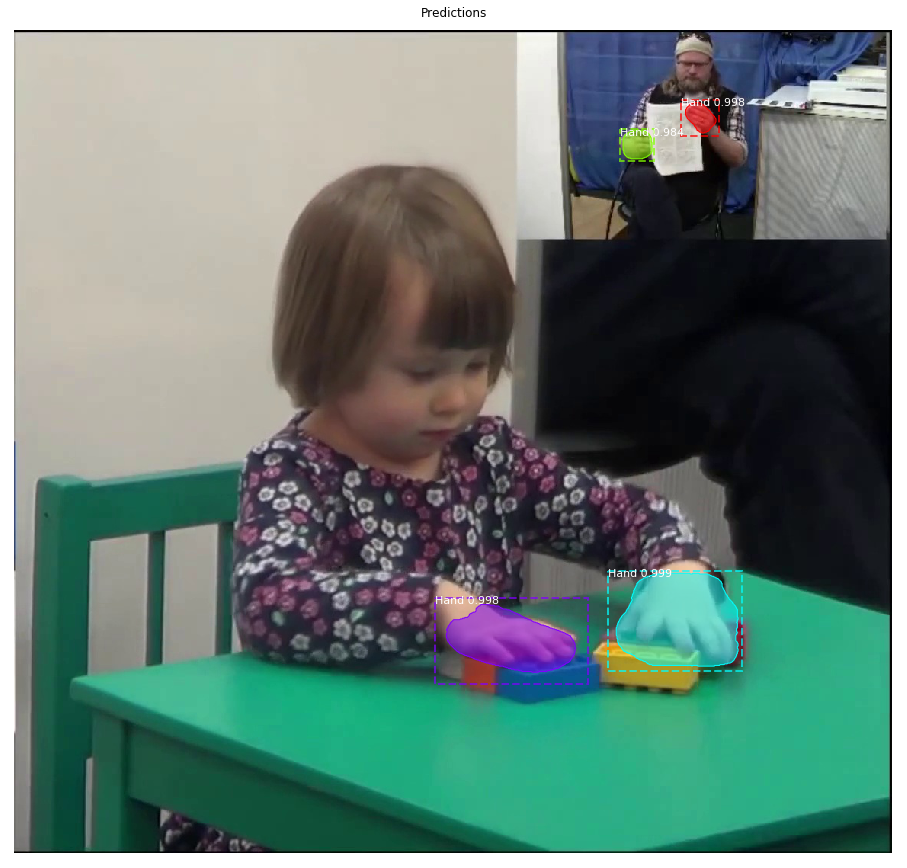

In [13]:
frame_path = "/scratch/shri/Projects/Hand-CNN/frame_output/Frame141.jpg"
img = skimage.io.imread(frame_path)
frames = []
# for files in os.listdir(frame_path)[:2]:
#     print(files)
#     frames.append(skimage.io.imread(frame_path+files)) 
# image = cv2.imread(frame_path)
# print(image)
# img_origin = skimage.io.imread(frame_path)
# img = img_origin.copy()
# print(np.shape(img))

# for frame in frames:
    
results = model.detect([img], verbose=0)

# results = model.detect([image], verbose=1)
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            ["BG","Hand"], r['scores'], ax=ax,
                            title="Predictions")

## Step by Step Prediction

#%% md

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

#%% md

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.
